In [89]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing

2024-05-16 15:15:49.751289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 15:15:49.751381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 15:15:49.916503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


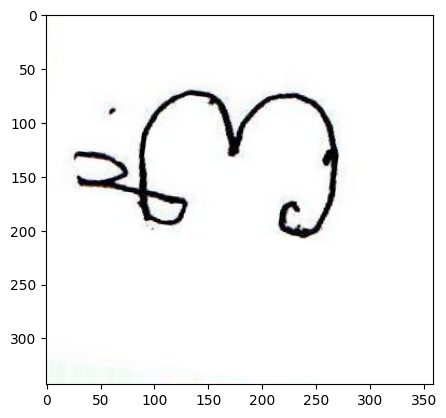

In [12]:
img = cv2.imread("/kaggle/input/tulu-handwritten-dataset/Tulu-Dtatset-V2/a/a_79.png")
plt.imshow(img)

In [6]:
img.shape

(346, 365, 3)

In [95]:
DATA_DIR = "/kaggle/input/tulu-handwritten-dataset/Tulu-Dtatset-V2"
IMG_SHAPE = (128,128, 3)

In [16]:
letters = os.listdir(DATA_DIR)
len(letters)

50

In [50]:
sample_image_paths = []

for i in letters:
    path = random.sample(glob(DATA_DIR+f"/{i}/"+"*.png"),k=1)
    sample_image_paths.append(str(path))

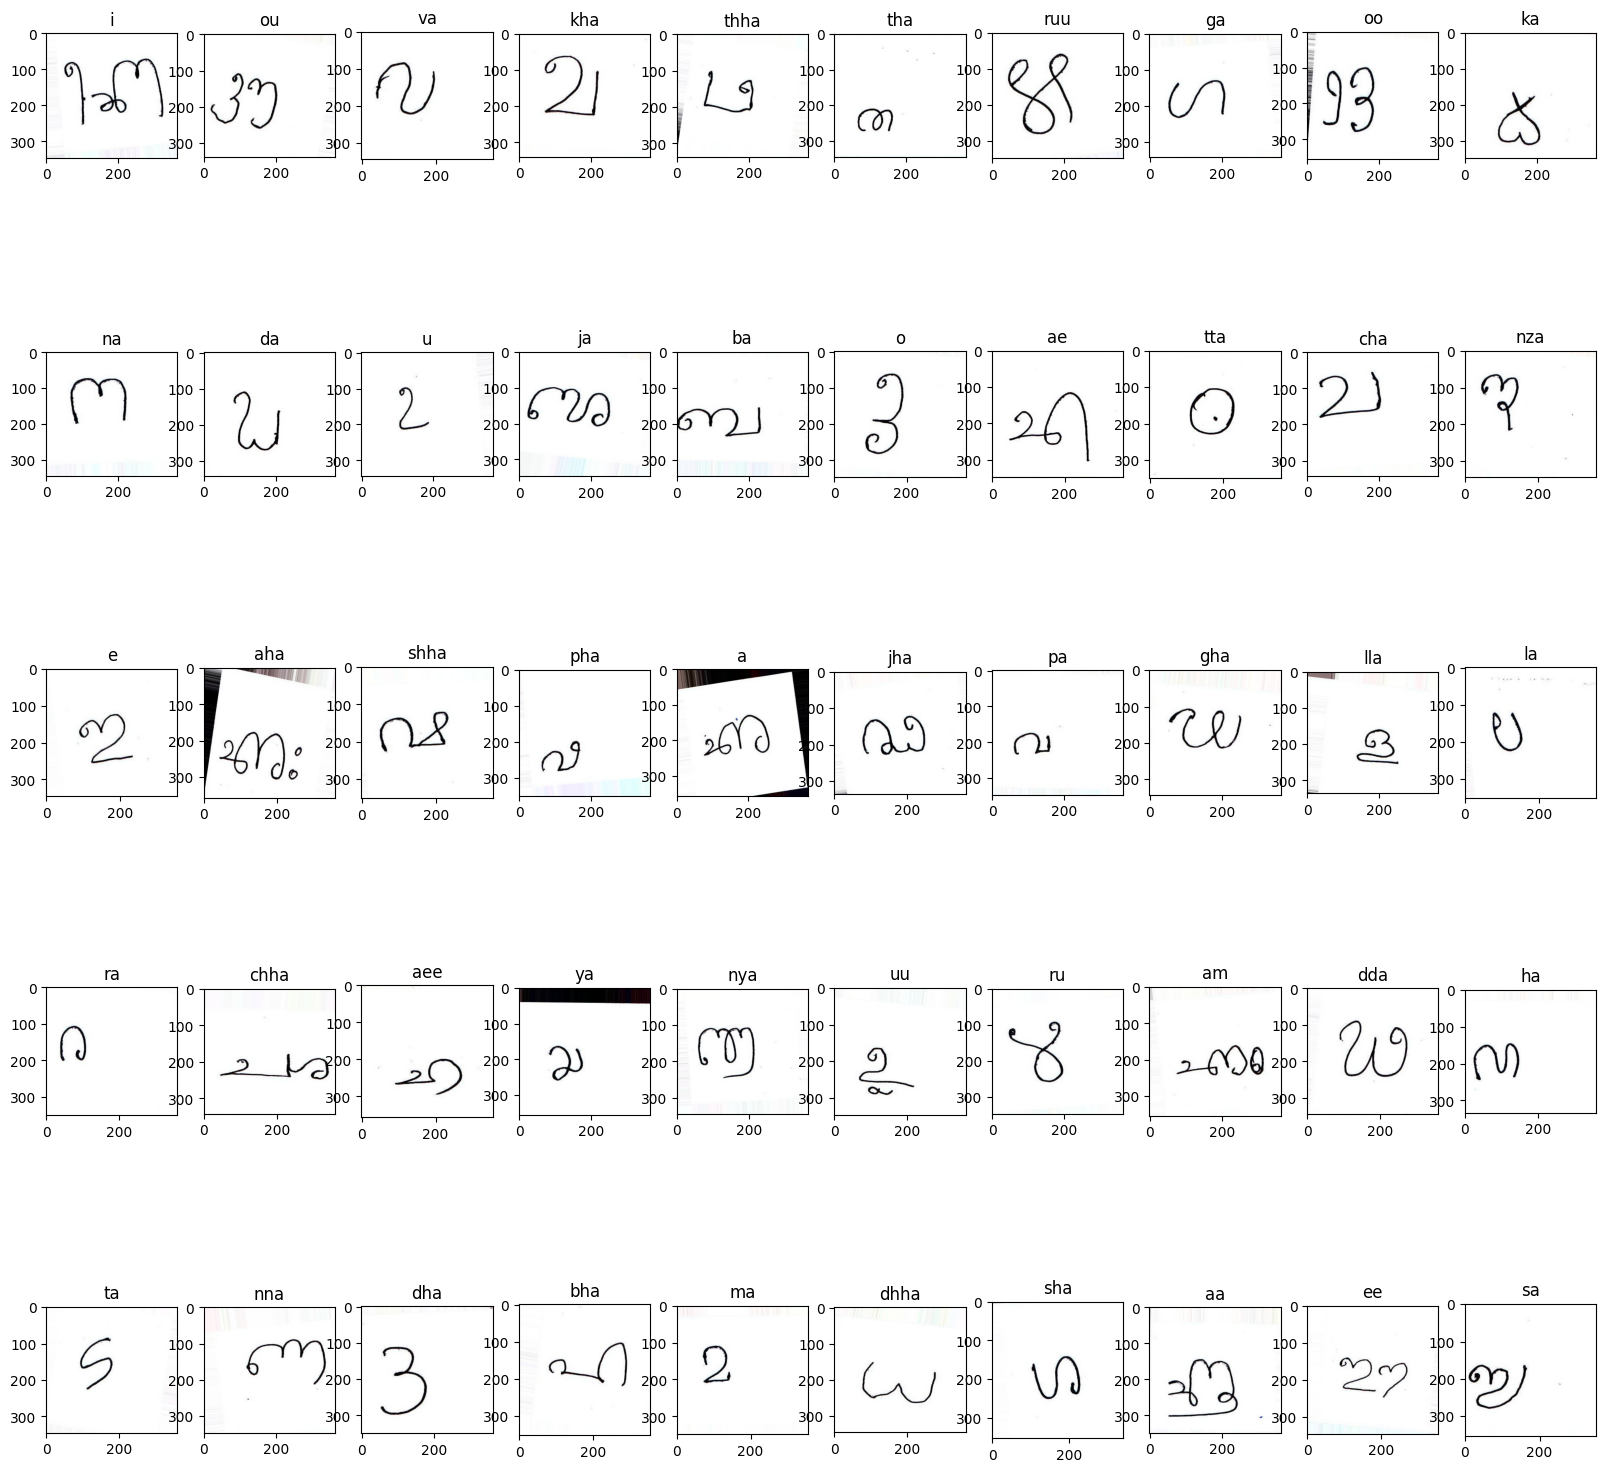

In [60]:
figs, axs = plt.subplots(5,10, figsize=(20,20))
idx=0

for col in range(10):
    for row in range(5):
        img_temp = cv2.imread(sample_image_paths[idx][2:-2])
        class_name = sample_image_paths[idx].split('/')[-2]
        axs[row, col].imshow(img_temp)
        axs[row, col].set_title(class_name)
        idx+=1

In [83]:
image_paths = []
class_labels = []

for i in letters:
    path = glob(os.path.join(DATA_DIR,i) + '/' + "*.png")
    image_paths.extend(path)
    class_labels.extend([i]*len(path))

In [86]:
df = pd.DataFrame(data={"Path":image_paths, "Label":class_labels})
df

,Path,Label
0,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
1,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
2,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
3,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
4,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,i
...,...,...
4974,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4975,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4976,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa
4977,/kaggle/input/tulu-handwritten-dataset/Tulu-Dt...,sa


In [87]:
df['Label'].value_counts()

Label
i       100
na      100
e       100
ra      100
ou      100
da      100
chha    100
aha     100
nna     100
u       100
ja      100
shha    100
aee     100
dha     100
pha     100
kha     100
thha    100
ya      100
nza     100
la      100
ba      100
tha     100
ma      100
uu      100
jha     100
o       100
ruu     100
ae      100
pa      100
dhha    100
ru      100
aa      100
gha     100
ga      100
ha      100
ka      100
ee      100
am      100
oo      100
cha     100
dda     100
lla     100
sa       99
ta       99
bha      99
tta      99
va       98
a        98
nya      98
sha      89
Name: count, dtype: int64

In [90]:
X = df # Contains all columns.
y = df[['Label']] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=0.30,
                                                          random_state=40)

    # Split the temp dataframe into val and test dataframes.

df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=0.5,
                                                      random_state=40)

In [91]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [104]:
train_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)
test_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)

eff_model = EfficientNetV2M(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
eff_model.trainable = False
eff_output = eff_model.output 

x = Flatten()(eff_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(50, activation='softmax')(x)
eff_final_model = Model(eff_model.input, output)

In [98]:
BATCH_SIZE = 32
# We create a Learning Rate Reducer that will reduce the learning rate by half if the validation loss does not decrease in 4 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose = 1)

# We stop the model training if we see no improvement (reduction in validation loss) for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

In [106]:
LR = 0.0003
eff_final_model.compile(optimizer = 'adam',
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])
train_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_efficientnet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="Path",
    y_col="Label",
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 3485 validated image filenames belonging to 50 classes.
Found 747 validated image filenames belonging to 50 classes.
Found 747 validated image filenames belonging to 50 classes.


EfficientNet

In [128]:
history_efficientnet = eff_final_model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.6449 - loss: 1.0988 - val_accuracy: 0.8367 - val_loss: 0.5806 - learning_rate: 5.0000e-04
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.6668 - loss: 1.0580 - val_accuracy: 0.8327 - val_loss: 0.5603 - learning_rate: 5.0000e-04
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.6727 - loss: 1.0016 - val_accuracy: 0.8675 - val_loss: 0.5125 - learning_rate: 5.0000e-04
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.6839 - loss: 1.0094 - val_accuracy: 0.8527 - val_loss: 0.5496 - learning_rate: 5.0000e-04
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.6859 - loss: 1.0337 - val_accuracy: 0.8420 - val_loss: 0.5663 - learning_rate: 5.0000e-04
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.7084 - loss: 0.9245 - val_accuracy: 0.8594 - val_loss: 0.5083 - learning_rate: 5.0000e-04
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 17

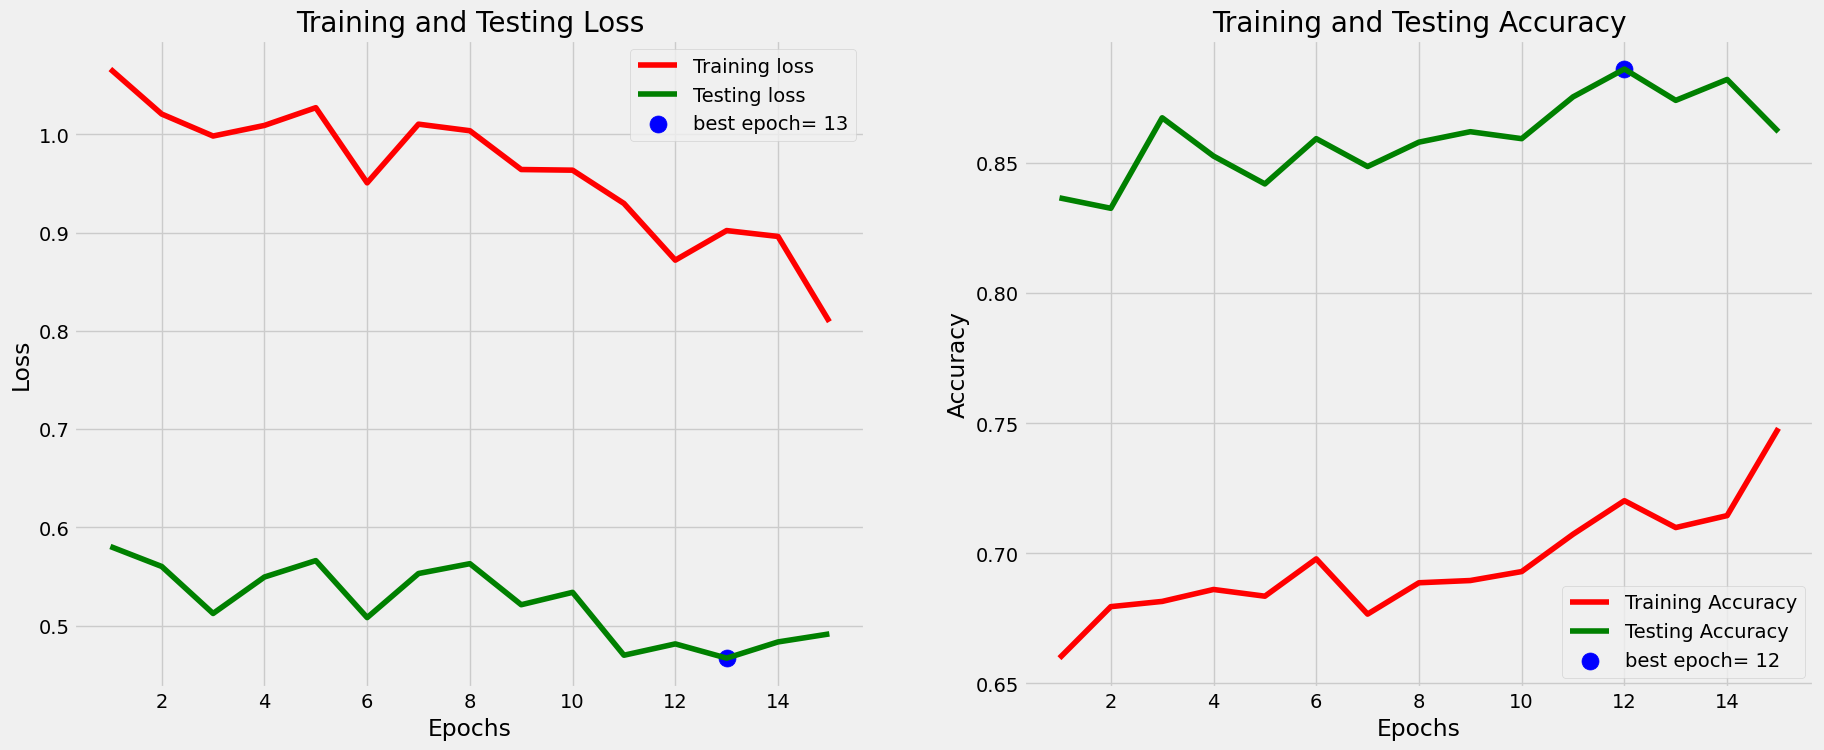

In [129]:
plot_training(history_efficientnet)

InceptionNet

In [111]:
train_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing, horizontal_flip=True, vertical_flip=True)
val_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)
test_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)

In [119]:
inception_model =  InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception_model_output = inception_model.output

x = Flatten()(inception_model_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
inception_output = Dense(50, activation='softmax')(x)
inception_final = Model(inception_model.input, inception_output)

In [120]:
LR = 0.0003
inception_final.compile(optimizer = 'adam',
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [125]:
history_inception = inception_final.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.8255 - loss: 0.5586 - val_accuracy: 0.8969 - val_loss: 0.5261 - learning_rate: 6.2500e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.8338 - loss: 0.5205 - val_accuracy: 0.8969 - val_loss: 0.4026 - learning_rate: 6.2500e-05
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.8388 - loss: 0.4986 - val_accuracy: 0.8876 - val_loss: 0.4473 - learning_rate: 6.2500e-05
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.8434 - loss: 0.4702 - val_accuracy: 0.9076 - val_loss: 0.4172 - learning_rate: 6.2500e-05
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.8415 - loss: 0.4763 - val_accuracy: 0.7979 - val_loss: 0.8495 - learning_rate: 6.2500e-05
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8493 - loss: 0.4477
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/st

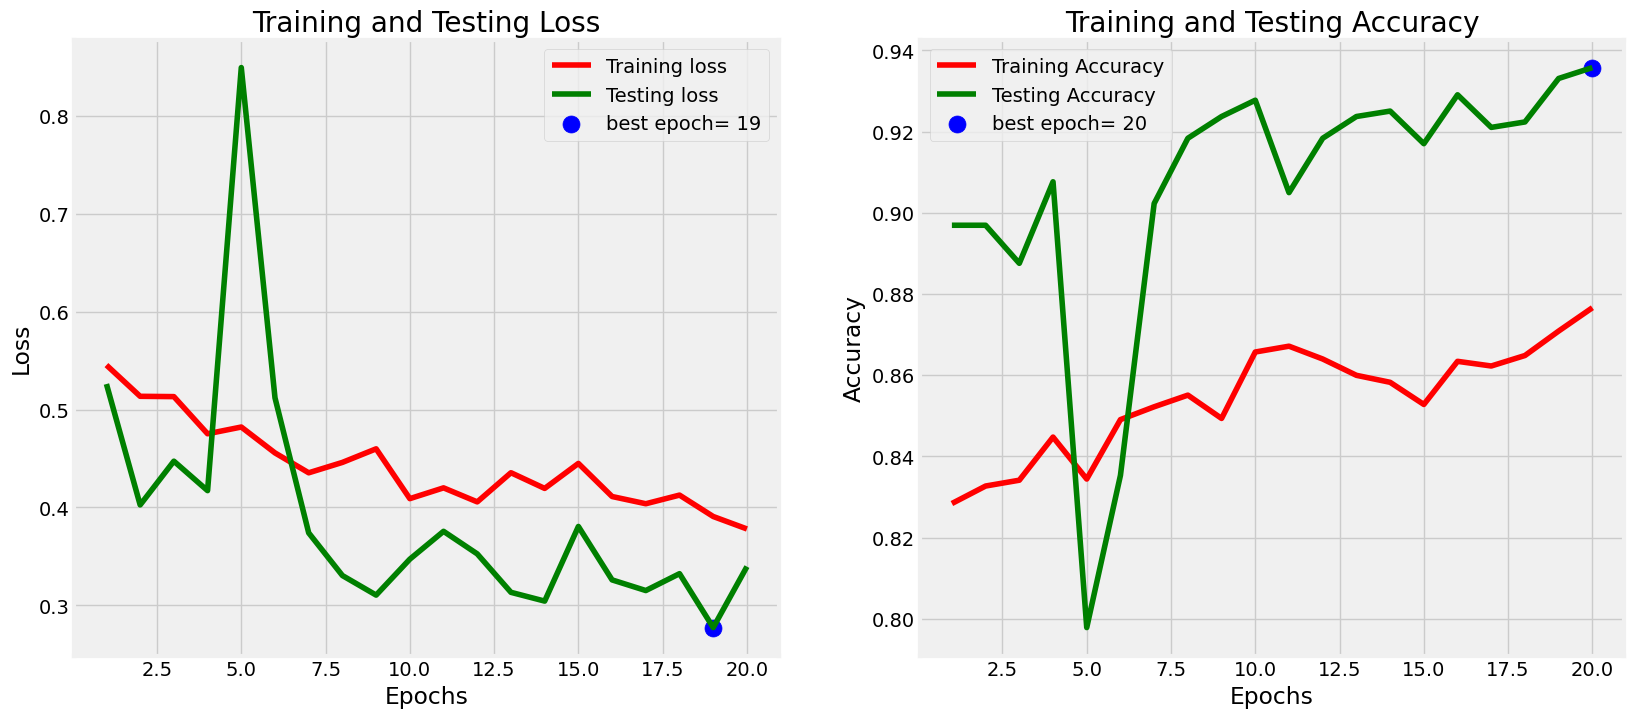

In [126]:
plot_training(history_inception)

DenseNet 

In [130]:
train_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)
test_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)

In [132]:
densenet_model = DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
densenet_model_output = densenet_model.output

x = Flatten()(densenet_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
densenet_out = Dense(50,activation='softmax')(x)
densenet_m = Model(densenet_model.input, densenet_out)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [134]:
LR = 0.0003
densenet_m.compile(optimizer = 'adam',
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [136]:
history_densenet = densenet_m.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.6978 - loss: 0.9644 - val_accuracy: 0.1606 - val_loss: 7.8640 - learning_rate: 0.0010
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.7712 - loss: 0.7055 - val_accuracy: 0.5181 - val_loss: 2.3351 - learning_rate: 0.0010
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.7995 - loss: 0.6445 - val_accuracy: 0.6613 - val_loss: 1.2872 - learning_rate: 0.0010
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.8027 - loss: 0.6067 - val_accuracy: 0.8260 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.8318 - loss: 0.5209 - val_accuracy: 0.2182 - val_loss: 5.3325 - learning_rate: 0.0010
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.8336 - loss: 0.5269 - val_accuracy: 0.5408 - val_loss: 1.9474 - learning_rate: 0.0010
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.8

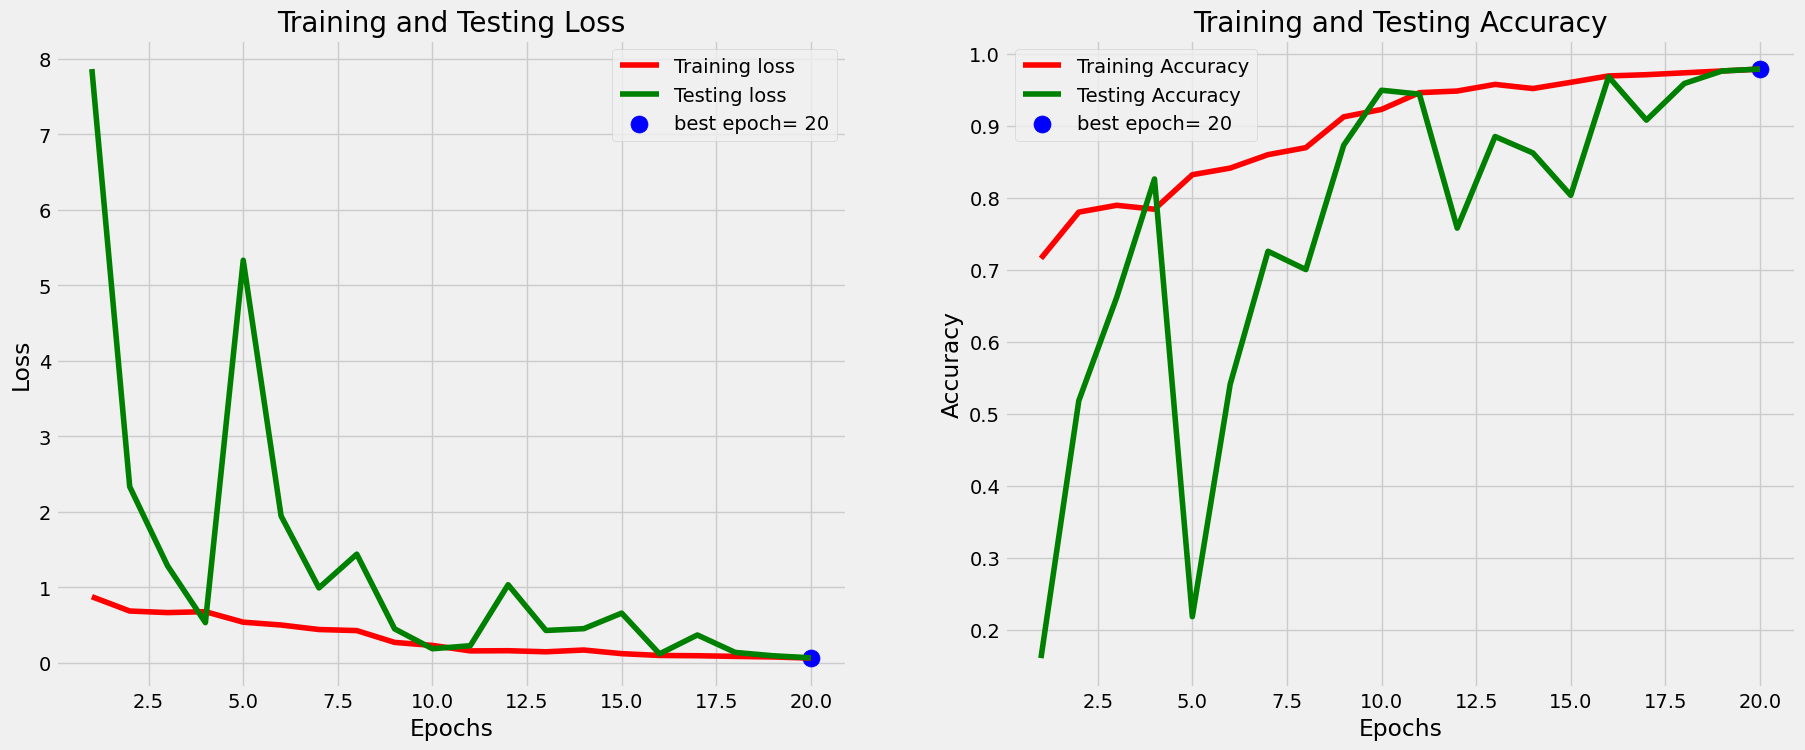

In [137]:
plot_training(history_densenet)